In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Descargar datos
data = yf.download('BHP', start='2020-01-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,55.894084,56.406545,55.375490,55.936302,50.827592,3.252849e+06
std,8.988175,9.036764,8.952654,9.030858,9.003104,1.755506e+06
min,27.448708,28.483498,26.565565,27.591436,24.029583,6.951320e+05
25%,49.259590,49.734613,48.777876,49.275001,43.825510,2.195674e+06
50%,57.545000,58.067114,57.152702,57.693703,53.218954,2.796951e+06
75%,62.395001,62.900002,61.903062,62.382500,57.692253,3.762441e+06
max,72.720787,73.211418,72.033897,72.256912,67.587662,1.353843e+07


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,49.259590,49.304192,48.867085,48.991970,41.455849,1382193
2020-01-03,48.385368,48.911686,48.349689,48.661907,41.176556,1208438
2020-01-06,48.519180,48.706512,48.501339,48.608383,41.131264,771584
2020-01-07,48.438892,48.795719,48.429974,48.608383,41.131264,1014393
2020-01-08,48.795719,49.063335,48.706512,48.849243,41.335075,1317848


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,68.000000,68.169998,67.669998,67.820000,66.152298,1896800
2023-12-26,68.000000,68.449997,67.959999,68.220001,66.542465,1390200
2023-12-27,68.239998,68.989998,68.230003,68.889999,67.195984,2339200
2023-12-28,68.839996,69.110001,68.580002,68.620003,66.932625,1949500
2023-12-29,68.330002,68.550003,68.010002,68.309998,66.630249,1555200


In [9]:
# Crear la variable objetivo
data['Price_Change'] = data['Adj Close'].diff()
data['Target'] = np.where(data['Price_Change'] > 0, 1, 0)

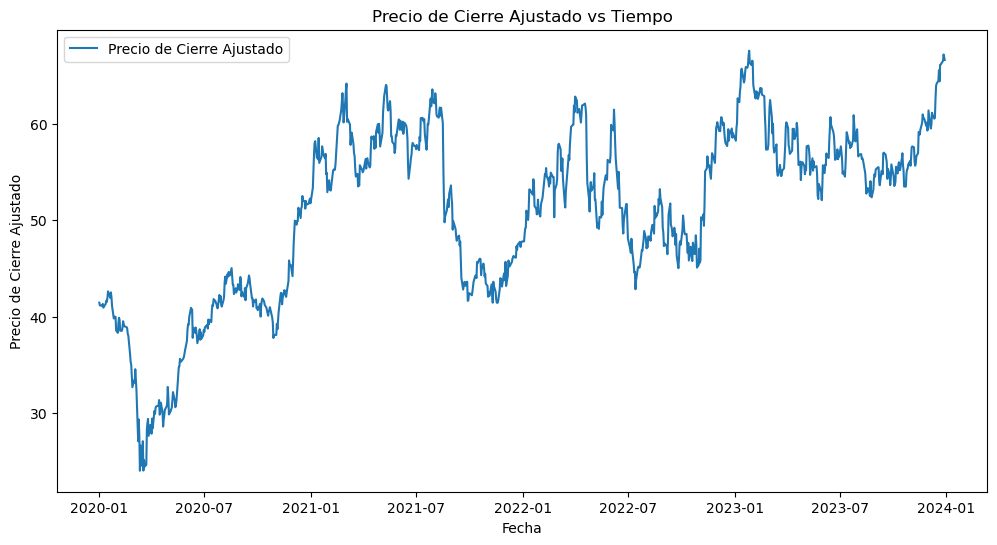

In [12]:
# 1. Gráfico del precio (Closing Price vs Time)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Precio de Cierre Ajustado')
plt.title('Precio de Cierre Ajustado vs Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

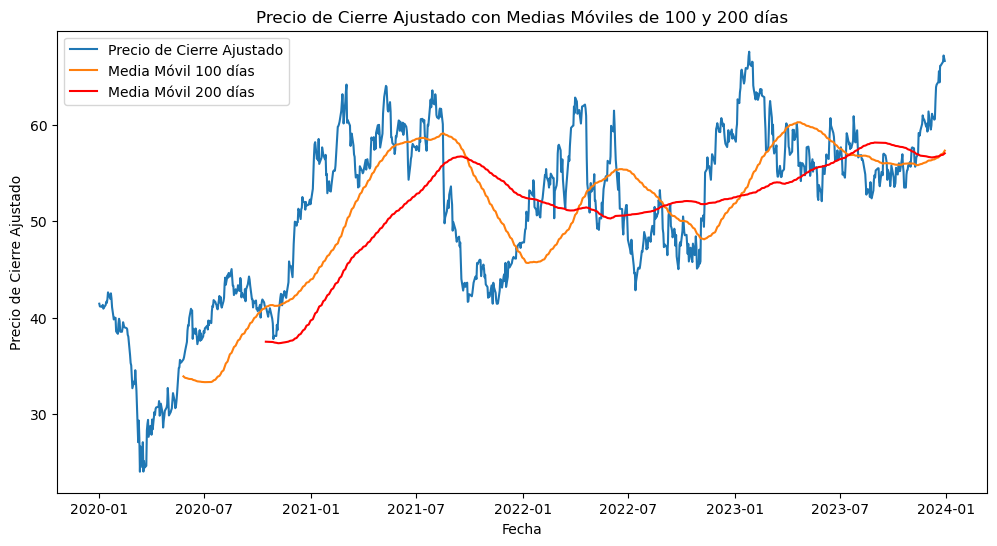

In [13]:
# 3. Gráfico de Closing Price vs Time con 100MA & 200MA
data['100MA'] = data['Adj Close'].rolling(window=100).mean()
data['200MA'] = data['Adj Close'].rolling(window=200).mean()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Precio de Cierre Ajustado')
plt.plot(data.index, data['100MA'], label='Media Móvil 100 días')
plt.plot(data.index, data['200MA'], label='Media Móvil 200 días', color='red')
plt.title('Precio de Cierre Ajustado con Medias Móviles de 100 y 200 días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

In [14]:
# Preparar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1))

In [15]:
# Crear una función para generar datos en ventanas deslizantes
def create_dataset(dataset, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [16]:
# Definir el tamaño de la ventana
time_step = 60
X, y = create_dataset(scaled_data, data['Target'].values, time_step)

In [17]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Remodelar los datos para LSTM [muestras, time steps, características]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

C:\Users\harol\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Entrenar el modelo
model.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.5133 - loss: 0.6967
Epoch 2/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.5176 - loss: 0.6949
Epoch 3/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.5699 - loss: 0.6860
Epoch 4/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.5590 - loss: 0.6892
Epoch 5/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5298 - loss: 0.6912
Epoch 6/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5124 - loss: 0.6944
Epoch 7/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5504 - loss: 0.6910
Epoch 8/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.5014 - loss: 0.6965
Epoch 9/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5439 - loss: 0.6895
Epoch 10/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5581 - loss: 0.6890
Epoch 11/20
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5230 - loss: 0.6930
Epoch 12/20
756/756 ━━━━━━━━━━

In [22]:
# Hacer predicciones
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


In [23]:
# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0 102]
 [  0  87]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.46      1.00      0.63        87

    accuracy                           0.46       189
   macro avg       0.23      0.50      0.32       189
weighted avg       0.21      0.46      0.29       189



C:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


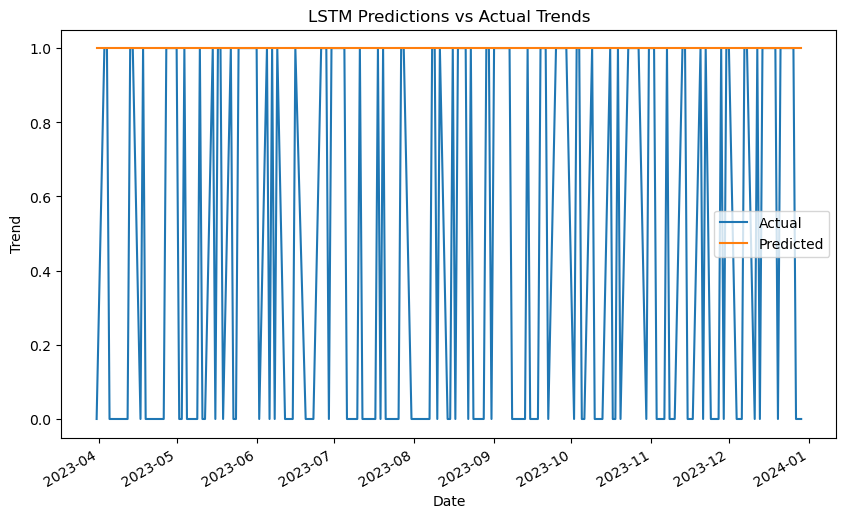

In [24]:
# Visualización de los resultados
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}, index=data.index[-len(y_test):])
results['Actual'].plot(label='Actual', figsize=(10, 6))
results['Predicted'].plot(label='Predicted')
plt.title('LSTM Predictions vs Actual Trends')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()
plt.show()

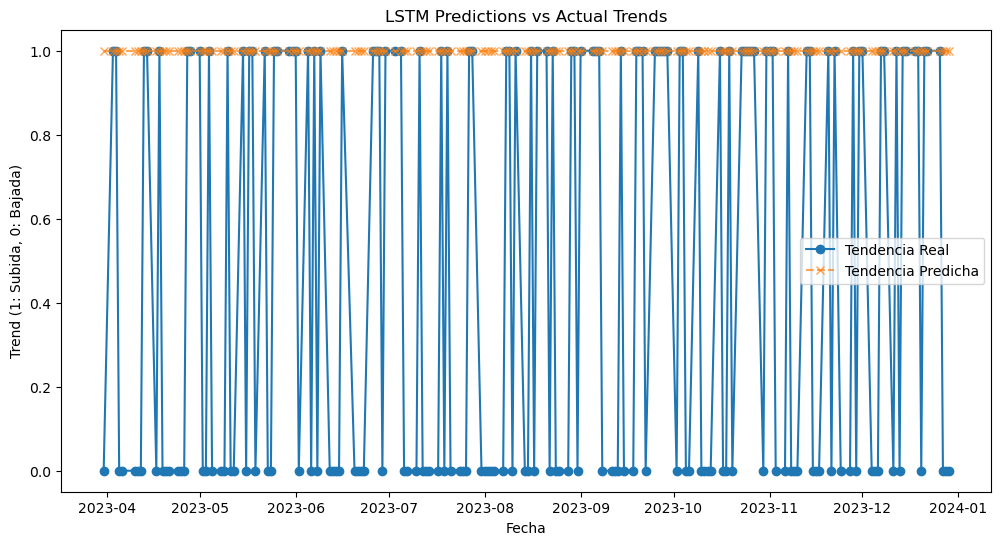

In [25]:
# 5. Precio Predicho vs Precio Original (Tendencias)
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual'], label='Tendencia Real', marker='o')
plt.plot(results.index, results['Predicted'], label='Tendencia Predicha', alpha=0.7, linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Trends')
plt.xlabel('Fecha')
plt.ylabel('Trend (1: Subida, 0: Bajada)')
plt.legend()
plt.show()

In [26]:
# Predicción para el siguiente día
last_60_days = scaled_data[-time_step:]
X_next_day = last_60_days.reshape(1, time_step, 1)
next_day_prediction_prob = model.predict(X_next_day)
next_day_prediction = (next_day_prediction_prob > 0.5).astype(int)
trend = "subida" if next_day_prediction[0][0] == 1 else "bajada"
print(f"El precio de BHP tiene una tendencia de {trend} para el siguiente día.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
El precio de BHP tiene una tendencia de subida para el siguiente día.
